# Import data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [3]:
df = pd.read_csv('drive/MyDrive/state_CA-IL.csv')

/tmp/ipython-input-1873897187.py:1: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44,46,78,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/state_CA-IL.csv')


In [4]:
# remove people who have withdrawn applications
df_sub = df.loc[df['action_taken']!=4].copy()

# create binary target variable
# Category (1, 2, 5, 6, 8) fall into “Approve” (1) while Category (3,7) fall into “Reject” (0)
df_sub.loc[:, "decision"] = np.where(df_sub["action_taken"].isin([1, 2, 5, 6, 8]), 1, 0)


# Question 1: Descriptive analysis on approved loans between Illinois and California originated in 2020

In [40]:
# Application volumn and approval and denial rates
df_count = pd.pivot_table(df_sub[["state_code", "decision"]], index="state_code", columns="decision", aggfunc="size")
df_pct = df_count.div(df_count.sum(axis=1), axis=0).mul(100).round(2)
df_total = df_count.sum(axis=1)
df_summary = pd.concat({"count": df_count, "total": df_total, "pct": df_pct}, axis=1)

df_summary

count             total    pct       
                 0        1        0      0      1
state_code                                        
CA          348758  2607848  2956606  11.80  88.20
IL           88883   674717   763600  11.64  88.36

In [41]:
# Approved subset
df_1 = df_sub[df_sub["decision"]==1]


## property value

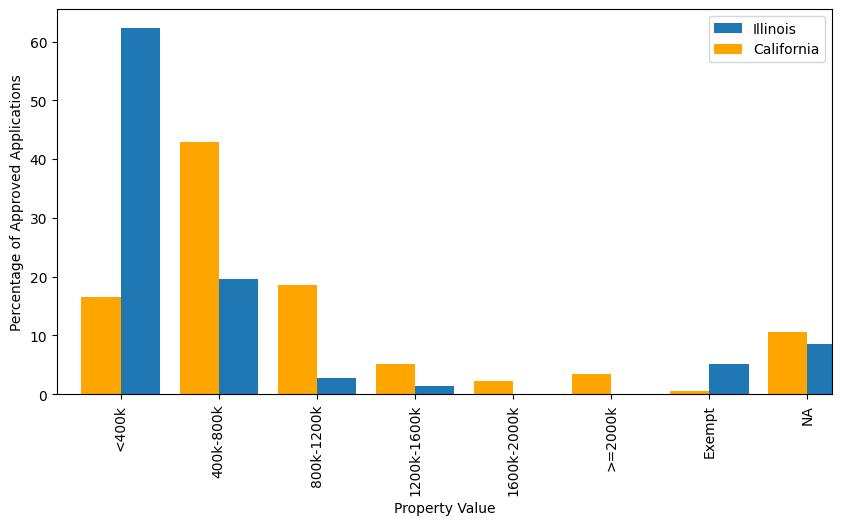

In [68]:
col = 'property_value'; str_value = 'Exempt'
bin_lower = 0; bin_upper = 20E5
bin_n = 6; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1]/1000))+'k')
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]/1000))+'k-'+str(int(bins[i+1]/1000))+'k')
  labels.append('>='+str(int(bins[-1]/1000))+'k')
else:
  labels.append('<'+str(bins[1]/1000)+'k')
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i]/1000)+'k-'+str(bins[i+1]/1000)+'k')
  labels.append('>='+str(bins[-1]/1000)+'k')



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Property Value')

plt.legend()
plt.show()



## loan amount

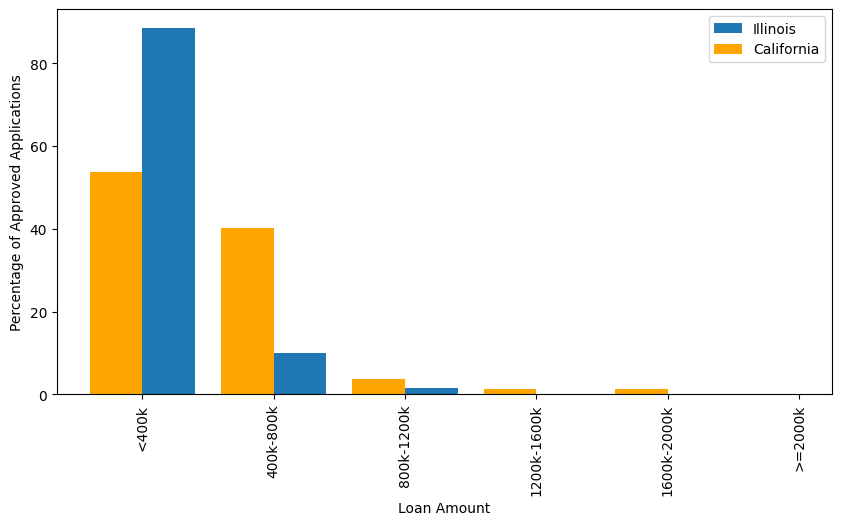

In [72]:
col = 'loan_amount'
bin_lower = 0; bin_upper = 20E5
bin_n = 6; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1]/1000))+'k')
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]/1000))+'k-'+str(int(bins[i+1]/1000))+'k')
  labels.append('>='+str(int(bins[-1]/1000))+'k')
else:
  labels.append('<'+str(bins[1]/1000)+'k')
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i]/1000)+'k-'+str(bins[i+1]/1000)+'k')
  labels.append('>='+str(bins[-1]/1000)+'k')



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

# dist_il[str_value] = il_exempt.sum()
# dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

# dist_ca[str_value] = ca_exempt.sum()
# dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Loan Amount')

plt.legend()
plt.show()



## LTV

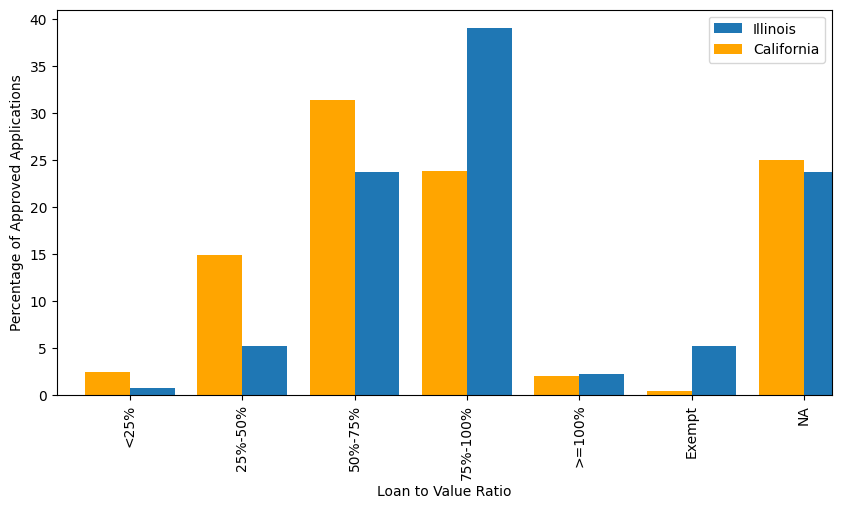

In [71]:
col = 'loan_to_value_ratio'; str_value = 'Exempt'
bin_lower = 0; bin_upper = 100
bin_n = 5; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1]))+'%')
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]))+'%-'+str(int(bins[i+1]))+'%')
  labels.append('>='+str(int(bins[-1]))+'%')
else:
  labels.append('<'+str(bins[1])+'%')
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i])+'%-'+str(bins[i+1])+'%')
  labels.append('>='+str(bins[-1])+'%')



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Loan to Value Ratio')

plt.legend()
plt.show()



## debt to income ratio

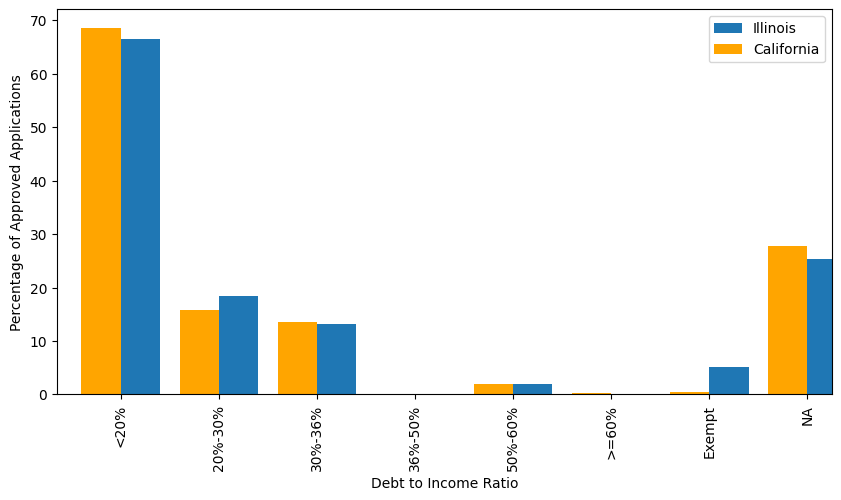

In [106]:
col = 'debt_to_income_ratio'; str_value = 'Exempt'

df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


# create labels
bins = [0, 20, 30, 36, 50, 60]
labels = ["<20%", "20%-30%", "30%-36%", "36%-50%", "50%-60%", ">=60%"]

# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['value'] = np.where(df_il[col]=='20%-<30%', 25, 0)
df_il['value'] = np.where(df_il[col]=='30%-<36%', 33, df_il['value'])
df_il['value'] = np.where(df_il[col]=='36%-50%', 43, df_il['value'])
df_il['value'] = np.where(df_il[col]=='50%-60%', 55, df_il['value'])
df_il['value'] = np.where(df_il[col]=='>60%', 65, df_il['value'])


df_il['num'] = pd.to_numeric(df_il['value'], errors='coerce')
is_numeric = df_il['num'].notna()

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'num'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['value'] = np.where(df_ca[col]=='20%-<30%', 25, 0)
df_ca['value'] = np.where(df_ca[col]=='30%-<36%', 33, df_ca['value'])
df_ca['value'] = np.where(df_ca[col]=='36%-50%', 43, df_ca['value'])
df_ca['value'] = np.where(df_ca[col]=='50%-60%', 55, df_ca['value'])
df_ca['value'] = np.where(df_ca[col]=='>60%', 65, df_ca['value'])


df_ca['num'] = pd.to_numeric(df_ca['value'], errors='coerce')
is_numeric = df_ca['num'].notna()

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'num'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Debt to Income Ratio')

plt.legend()
plt.show()



## interest rate

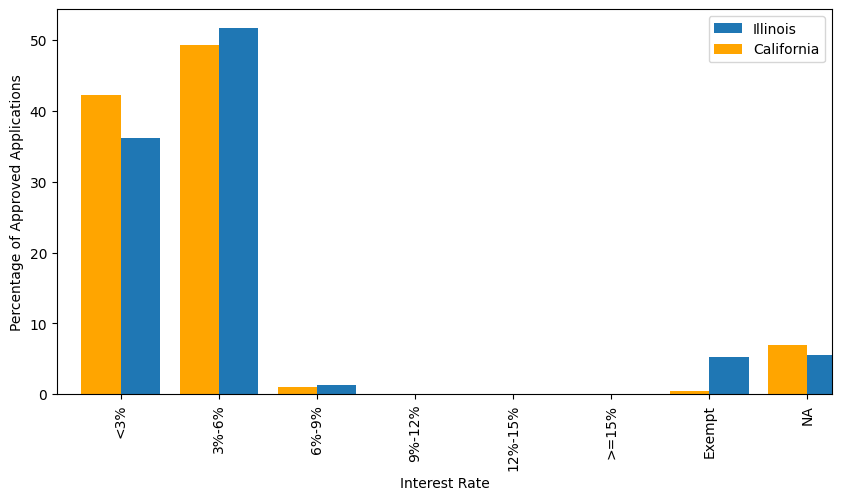

In [58]:
# winsorize the numerical values as some interest rate > 20% which seems unrealistic
col = 'interest_rate'; str_value = 'Exempt'
bin_lower = 0; bin_upper = 15
bin_n = 6; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1]))+'%')
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]))+'%-'+str(int(bins[i+1]))+'%')
  labels.append('>='+str(int(bins[-1]))+'%')
else:
  labels.append('<'+str(bins[1])+'%')
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i])+'%-'+str(bins[i+1])+'%')
  labels.append('>='+str(bins[-1])+'%')



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Interest Rate')

plt.legend()
plt.show()



## rate spread

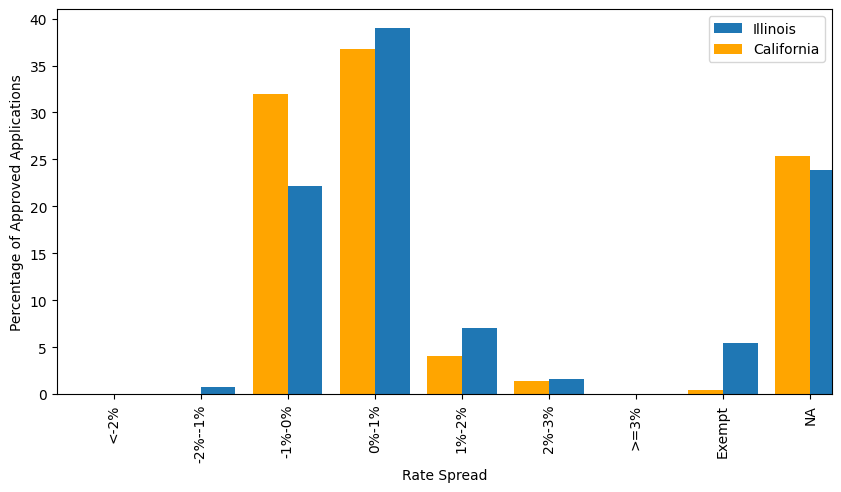

In [82]:
# winsorize the numerical values
col = 'rate_spread'; str_value = 'Exempt'
bin_lower = -2; bin_upper = 3
bin_n = 6; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[0]))+'%')
  for i in range(0, len(bins)-1):
    labels.append(str(int(bins[i]))+'%-'+str(int(bins[i+1]))+'%')
  labels.append('>='+str(int(bins[-1]))+'%')
else:
  labels.append('<'+str(bins[1])+'%')
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i])+'%-'+str(bins[i+1])+'%')
  labels.append('>='+str(bins[-1])+'%')



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=[-np.inf]+list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=[-np.inf]+list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Rate Spread')

plt.legend()
plt.show()



## loan term

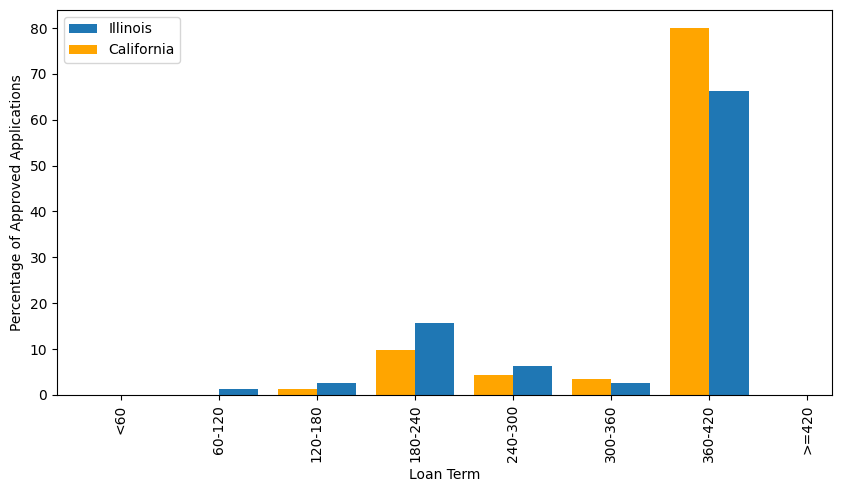

In [43]:
col = 'loan_term'; str_value = 'Exempt'
bin_lower = 0; bin_upper = 420
bin_n = 8; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1])))
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]))+'-'+str(int(bins[i+1])))
  labels.append('>='+str(int(bins[-1])))
else:
  labels.append('<'+str(bins[1]))
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i])+'-'+str(bins[i+1]))
  labels.append('>='+str(bins[-1]))



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

# dist_il[str_value] = il_exempt.sum()
# dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

# dist_ca[str_value] = ca_exempt.sum()
# dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Loan Term')

plt.legend()
plt.show()




## lender credits

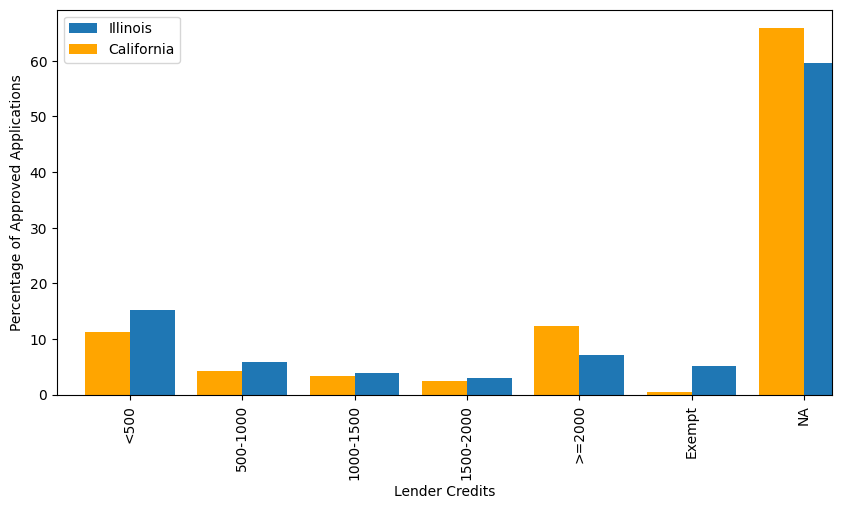

In [96]:
# winsorize the numerical values as some interest rate > 20% which seems unrealistic
col = 'lender_credits'; str_value = 'Exempt'
bin_lower = 0; bin_upper = 2000
bin_n = 5; bin_int = True


df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)


bins = np.linspace(bin_lower, bin_upper, bin_n)

# create labels
labels = []

if bin_int == True:
  labels.append('<'+str(int(bins[1])))
  for i in range(1, len(bins)-1):
    labels.append(str(int(bins[i]))+'-'+str(int(bins[i+1])))
  labels.append('>='+str(int(bins[-1])))
else:
  labels.append('<'+str(bins[1]))
  for i in range(2, len(bins)-1):
    labels.append(str(bins[i])+'-'+str(bins[i+1]))
  labels.append('>='+str(bins[-1]))



# IL
il_exempt = df_il[col].astype(str).str.lower() == str_value.lower()
il_na = df_il[col].isna()

df_il['num'] = pd.to_numeric(df_il[col], errors='coerce')
is_numeric = df_il['num'].notna()

lower = df_il.loc[is_numeric, 'num'].quantile(0.01)
upper = df_il.loc[is_numeric, 'num'].quantile(0.99)

df_il.loc[is_numeric, 'winsorize'] = (df_il.loc[is_numeric, 'num'].clip(lower, upper))

df_il.loc[is_numeric, 'bin'] = pd.cut(df_il.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_il)

dist_il = df_il.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_il[str_value] = il_exempt.sum()
dist_il['NA'] = il_na.sum()

dist_il_pct = dist_il / total_n * 100




# CA
ca_exempt = df_ca[col].astype(str).str.lower() == str_value.lower()
ca_na = df_ca[col].isna()

df_ca['num'] = pd.to_numeric(df_ca[col], errors='coerce')
is_numeric = df_ca['num'].notna()

lower = df_ca.loc[is_numeric, 'num'].quantile(0.01)
upper = df_ca.loc[is_numeric, 'num'].quantile(0.99)

df_ca.loc[is_numeric, 'winsorize'] = (df_ca.loc[is_numeric, 'num'].clip(lower, upper))

df_ca.loc[is_numeric, 'bin'] = pd.cut(df_ca.loc[is_numeric, 'winsorize'],
                                bins=list(bins)+[np.inf], labels=labels, right=False)

# count
total_n = len(df_ca)

dist_ca = df_ca.loc[is_numeric, 'bin'].value_counts(dropna=False).sort_index()

dist_ca[str_value] = ca_exempt.sum()
dist_ca['NA'] = ca_na.sum()

dist_ca_pct = dist_ca / total_n * 100



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Lender Credits')

plt.legend()
plt.show()



## applicant age

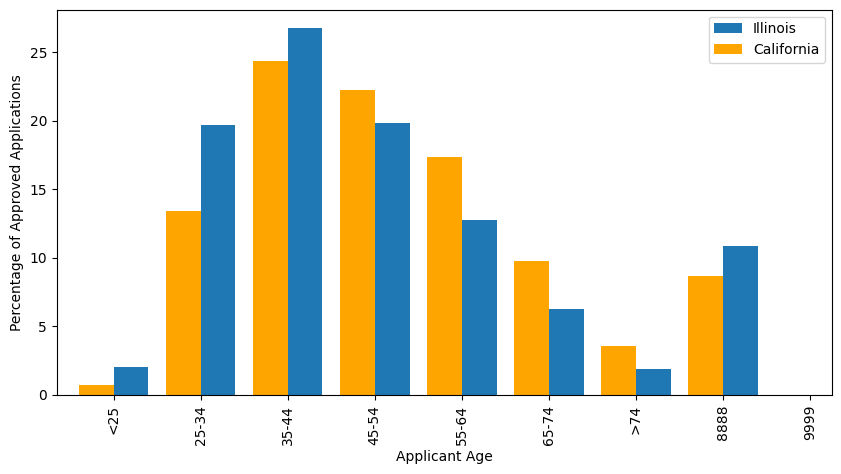

In [115]:
col = 'applicant_age'

df_il = df_1[df_1['state_code']=='IL'].reset_index(drop=True)
df_ca = df_1[df_1['state_code']=='CA'].reset_index(drop=True)

# IL
total_n = len(df_il)

dist_il = df_il.loc[:, col].value_counts(dropna=False).sort_index()
dist_il_pct = dist_il / total_n * 100


# CA
total_n = len(df_ca)

dist_ca = df_ca.loc[:, col].value_counts(dropna=False).sort_index()

dist_ca_pct = dist_ca / total_n * 100

label_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', '8888', '9999']
dist_il_pct = dist_il_pct.reindex(label_order)
dist_ca_pct = dist_ca_pct.reindex(label_order)



# plot
plt.figure(figsize=(10, 5))

dist_il_pct.plot(kind='bar', width=0.4, position=0, label='Illinois')
dist_ca_pct.plot(kind='bar', width=0.4, position=1, label='California', color='orange')

plt.ylabel('Percentage of Approved Applications')
plt.xlabel('Applicant Age')

plt.legend()
plt.show()


# Question 2: Predict denial / approval of a mortgage application using Illinois 2020 dataset

In [5]:
df_sub_il = df_sub.loc[df_sub["state_code"]=="IL"].reset_index(drop=True)


In [6]:
# informational columns to be excluded from modeling
info_col = ['action_taken', 'activity_year', 'lei',
            'derived_msa-md', 'state_code', 'aus-1',
            'aus-2', 'aus-3', 'aus-4',
            'aus-5', 'denial_reason-1', 'denial_reason-2',
            'denial_reason-3', 'denial_reason-4']

df_il_model = df_sub_il.drop(columns=info_col).copy()


In [7]:
# important features: if na, yield manual review
# drop na for these values
impt_col = ['loan_amount', 'interest_rate', 'loan_term', 'property_value']

df_il_model_1 = df_il_model.dropna(subset=impt_col).copy()

print("{:.2f}% of the data is missing important product information.".format(
    (1 - df_il_model_1.shape[0] / df_il_model.shape[0]) * 100))


19.02% of the data is missing important product information.


In [8]:
# numerical columns to be cleaned
num_col = ['loan_amount', 'loan_to_value_ratio', 'interest_rate',
            'rate_spread', 'total_loan_costs', 'origination_charges',
            'discount_points', 'lender_credits', 'loan_term',
            'prepayment_penalty_term', 'intro_rate_period', 'property_value',
            'income', 'debt_to_income_ratio', 'tract_population',
            'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
            'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units']


for col in num_col:
  if 'Exempt' in df_il_model[col].unique():
    # Create exempt flag
    exempt_flag = f"{col}_exempt"
    df_il_model[exempt_flag] = (df_il_model[col] == "Exempt").astype(int)

    df_il_model[col] = df_il_model[col].replace("Exempt", np.nan)

  df_il_model[col] = pd.to_numeric(df_il_model[col], errors="coerce")



In [9]:
# Compute LTV
df_il_model["loan_to_value_ratio"] = np.where(df_il_model["loan_to_value_ratio"].isna(),
                df_il_model["loan_amount"] / df_il_model["property_value"], df_il_model["loan_to_value_ratio"])


In [10]:
# onehot encoding for categorical variables
category_col = []
for col in df_il_model.columns:
  if col not in num_col:
    if col != 'decision':
      if "exempt" not in col.lower():
        category_col.append(col)

df_il_model_encoded = pd.get_dummies(df_il_model, columns=category_col, drop_first=True)


In [24]:
df_il_model_1["decision"].value_counts(normalize=True)

,proportion
decision,
1,0.994848
0,0.005152


In [11]:
df_il_decision = df_il_model["decision"].value_counts(normalize=True)
df_il_decision

,proportion
decision,
1,0.8836
0,0.1164


## XGB

In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, ParameterSampler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, confusion_matrix


In [13]:
# stratified random sampling on original dataset due to limited computing resources
df_il_model_encoded_sub, _ = train_test_split(
    df_il_model_encoded,
    test_size=0.9,
    stratify=df_il_model_encoded['decision'],
    random_state=42
)


In [14]:
# X, y --> train 60%, val 20%, test 20%
X = df_il_model_encoded_sub.drop(columns=["decision"])  # or your target col
y = df_il_model_encoded_sub["decision"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2,
    stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
    test_size=0.25, stratify=y_train_full, random_state=42)


In [15]:
# use scale_pos_weight since data is imbalanced
scale_pos_weight = float(df_il_decision[1] / df_il_decision[0])
print("scale_pos_weight: ", scale_pos_weight)


scale_pos_weight:  7.59106915833174


In [16]:
# hyperparameter tuning
param_dist = {
    "n_estimators": [300, 500, 800],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.03, 0.05],
    "min_child_weight": [10, 30, 50],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.2, 0.5],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [5, 10, 20],
    "scale_pos_weight": [5, 7.5, 10, 12]
}

best_score = -np.inf
best_model = None

for params in ParameterSampler(param_dist, n_iter=30, random_state=42):

    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        missing=np.nan,
        random_state=42,
        n_jobs=-1
    )

    model.fit(
        X_train.values,
        y_train.values,
        eval_set=[(X_val.values, y_val.values)],
        # early_stopping_rounds=30,
        verbose=False
    )

    val_scores = model.predict_proba(X_val.values)[:, 1]
    score = average_precision_score(y_val.values, val_scores)

    if score > best_score:
        best_score = score
        best_model = model


In [17]:
print("best_score: ", best_score)
print("best_model: ", best_model.get_params())


best_score:  0.9999465936074406
best_model:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'feature_weights': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 800, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 20, 'sampling_method': None, 'scale_pos_weight': 7.5, 'subsample': 0.6, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [18]:
# train xgb model with best params
best_params = {
    "n_estimators": 800,
    "max_depth": 3,
    "learning_rate": 0.05,
    "min_child_weight": 10,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "gamma": 0.2,
    "reg_alpha": 0,
    "reg_lambda": 20,
    "scale_pos_weight": 7.5
}

best_model = XGBClassifier(
        **best_params,
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        missing=np.nan,
        random_state=42,
        n_jobs=-1
    )

best_model.fit(X_train.values, y_train.values)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=-1, num_parallel_tree=None, ...)

In [35]:
best_model.feature_importances_

array([0.00370035, 0.05881257, 0.13377464, ..., 0.00396947, 0.        ,
       0.        ], dtype=float32)

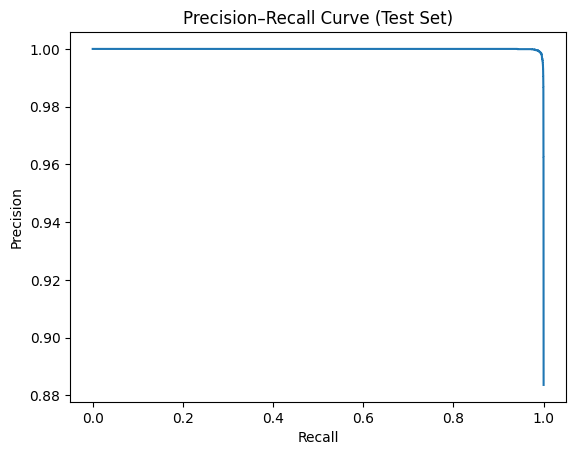

In [28]:
# test data
y_prob = best_model.predict_proba(X_test.values)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test.values, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.show()


In [29]:
# optimal f1
# precision_recall_curve returns thresholds with length = len(precision)-1
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("The optimal threshold is {:.2f}.".format(best_threshold))


The optimal threshold is 0.91.


In [47]:
y_pred_opt = (y_prob >= best_threshold).astype(int)

accuracy_opt = accuracy_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
confusion_matrix_opt = confusion_matrix(y_test, y_pred_opt)

print("Accuracy: {:.4f}".format(accuracy_opt))
print("ROC-AUC: {:.4f}".format(roc_auc_opt))
print("Precision: {:.4f}".format(precision_opt))
print("Recall: {:.4f}".format(recall_opt))
print("F1 score: {:.4f}".format(f1_opt))
print("Confusion matrix: \n", confusion_matrix_opt)


Accuracy: 0.9946
ROC-AUC: 0.9894
Precision: 0.9977
Recall: 0.9962
F1 score: 0.9970
Confusion matrix: 
 [[ 1747    31]
 [   51 13443]]


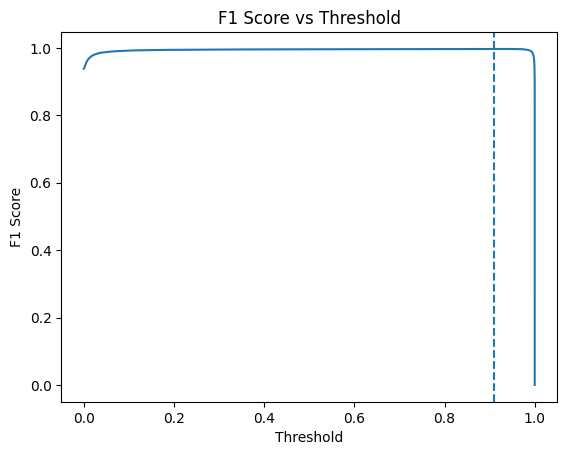

In [34]:
plt.figure()
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.show()


In [48]:
# training data
y_train_prob = best_model.predict_proba(X_train.values)[:, 1]

y_train_pred_opt = (y_train_prob >= best_threshold).astype(int)

accuracy_opt = accuracy_score(y_train, y_train_pred_opt)
roc_auc_opt = roc_auc_score(y_train, y_train_pred_opt)
precision_opt = precision_score(y_train, y_train_pred_opt)
recall_opt = recall_score(y_train, y_train_pred_opt)
f1_opt = f1_score(y_train, y_train_pred_opt)
confusion_matrix_opt = confusion_matrix(y_train, y_train_pred_opt)

print("Accuracy: {:.4f}".format(accuracy_opt))
print("ROC-AUC: {:.4f}".format(roc_auc_opt))
print("Precision: {:.4f}".format(precision_opt))
print("Recall: {:.4f}".format(recall_opt))
print("F1 score: {:.4f}".format(f1_opt))
print("Confusion matrix: \n", confusion_matrix_opt)


Accuracy: 0.9957
ROC-AUC: 0.9914
Precision: 0.9981
Recall: 0.9969
F1 score: 0.9975
Confusion matrix: 
 [[ 5257    75]
 [  124 40360]]


In [39]:
# SHAP value
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test.values)

# Mean SHAP values (with direction)
shap_mean = shap_values.mean(axis=0)

shap_importance_direction = pd.DataFrame({
    "feature": X_test.columns,
    "mean_shap": shap_mean,
    "mean_abs_shap": np.abs(shap_mean)
}).sort_values("mean_abs_shap", ascending=False)

top_10_shap_direction = shap_importance_direction.head(10)
top_10_shap_direction




,feature,mean_shap,mean_abs_shap
2,interest_rate,2.520060,2.520060
3293,hoepa_status_3,1.313263,1.313263
3,rate_spread,0.764627,0.764627
3292,hoepa_status_2,0.426250,0.426250
1,loan_to_value_ratio,-0.342753,0.342753
11,property_value,-0.192152,0.192152
4681,occupancy_type_3,-0.097748,0.097748
4760,co-applicant_credit_score_type_10,-0.094886,0.094886
3288,open-end_line_of_credit_2,-0.092120,0.092120
17,tract_to_msa_income_percentage,-0.085352,0.085352
